<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

This will save files to your local machine if `save_files` is set to True.

# Change Inputs Here

In [1]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 4 #768 512

# model_name = "gpt2-small"

save_files = True
run_on_other_tasks = True

# Setup

In [2]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

# Load Model

In [6]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
# tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH, use_fast= False, add_prefix_space= False)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [9]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [10]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Test prompts

In [ ]:
words = ['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'once', 'doce']

In [11]:
# Get list of arguments to pass to `generate` (specifically these are the ones relating to sampling)
generate_kwargs = dict(
    do_sample = False, # deterministic output so we can compare it to the HF model
    top_p = 1.0, # suppresses annoying output errors
    temperature = 1.0, # suppresses annoying output errors
)

prompt =  "siete ocho nueve"
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

siete ocho nueve



In [13]:
prompt =  "siete ocho nueve "
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

siete ocho nueve 2


Because llama-2 tokenizer treats space as a token, remember to ablate even the spaces too, not just the numbers!

In [12]:
tokenizer.tokenize('siete ocho nueve diez')

['▁si', 'ete', '▁o', 'cho', '▁nue', 've', '▁die', 'z']

In [14]:
prompt =  "dos tres cuatro cinco"
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

dos tres quatro cinco seis


In [18]:
tokenizer.tokenize("dos tres cuatro cinco")

['▁dos', '▁tres', '▁cuatro', '▁cinco']

In [17]:
prompt =  "uno dos tres"
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

uno dos tres cuatro


In [15]:
prompt =  "dos tres quatro cinco seis"
output = model.generate(prompt, max_new_tokens=1, **generate_kwargs)
print(output)

  0%|          | 0/1 [00:00<?, ?it/s]

dos tres quatro cinco seis seven


# Import functions from repo

In [34]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 909, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 909 (delta 208), reused 284 (delta 121), pack-reused 534
Receiving objects: 100% (909/909), 17.08 MiB | 20.27 MiB/s, done.
Resolving deltas: 100% (571/571), done.
/content/seqcont_circuits/src/iter_node_pruning


In [35]:
# from dataset import Dataset
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# Generate dataset with multiple prompts

In [19]:
class Dataset:
    def __init__(self, prompts, tokenizer):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        ]

        pos_dict = {}
        # for i in range(1, 4):
        #     pos_dict['S'+str(i)] = i
        list_tokens = tokenizer.tokenize('2 4 6 ')
        for i, tok_as_str in enumerate(list_tokens):
            pos_dict['S'+str(i)] = i

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = self.tokenizer.tokenize(input_text)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [27]:
words = ['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'once', 'doce']

def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            # 'corr': ' '+words[i+4],
            # 'incorr': ' '+words[i+3],  # this is arbitrary
            # 'text': f"{words[i]} {words[i+1]} {words[i+2]} {words[i+3]}"
            'corr': ' '+words[i+3],
            'incorr': ' '+words[i+2],  # this is arbitrary
            'text': f"{words[i]} {words[i+1]} {words[i+2]}"
        }
        list_tokens = tokenizer.tokenize(prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            prompt_dict['S'+str(i)] = tok_as_str
        prompts_list.append(prompt_dict)
    return prompts_list

# prompts_list = generate_prompts_list(0, 8)
prompts_list = generate_prompts_list(0, 4)
prompts_list

[{'corr': ' cuatro',
  'incorr': ' tres',
  'text': 'uno dos tres',
  'S0': '▁uno',
  'S1': '▁dos',
  'S2': '▁tres'},
 {'corr': ' cinco',
  'incorr': ' cuatro',
  'text': 'dos tres cuatro',
  'S0': '▁dos',
  'S1': '▁tres',
  'S2': '▁cuatro'},
 {'corr': ' seis',
  'incorr': ' cinco',
  'text': 'tres cuatro cinco',
  'S0': '▁tres',
  'S1': '▁cuatro',
  'S2': '▁cinco'},
 {'corr': ' siete',
  'incorr': ' seis',
  'text': 'cuatro cinco seis',
  'S0': '▁cuatro',
  'S1': '▁cinco',
  'S2': '▁seis'}]

In [29]:
import random
# words = ['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'once', 'doce']
words = ['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis']

def generate_prompts_list_corr(prompt_list):
    outlist = []
    for prompt_dict in prompts_list:
        r1 = random.choice(words)
        # r2 = random.choice(words)
        while True:
            r3_ind = random.randint(0,len(words)-1)
            r4_ind = random.randint(0,len(words)-1)
            if words[r3_ind] != words[r4_ind-1]:
                break
        r3 = words[r3_ind]
        r4 = words[r4_ind]

        new_prompt_dict = {
            'corr': prompt_dict['corr'],
            'incorr': prompt_dict['incorr'],
            # 'text': f"{r1} {r2} {r3} {r4}"
            'text': f"{r1} {r3} {r4}"
        }
        list_tokens = tokenizer.tokenize(new_prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            new_prompt_dict['S'+str(i)] = tok_as_str
        outlist.append(new_prompt_dict)
    return outlist

prompts_list_2 = generate_prompts_list_corr(prompts_list)
prompts_list_2

[{'corr': ' cuatro',
  'incorr': ' tres',
  'text': 'cinco cuatro seis',
  'S0': '▁cinco',
  'S1': '▁cuatro',
  'S2': '▁seis'},
 {'corr': ' cinco',
  'incorr': ' cuatro',
  'text': 'dos tres uno',
  'S0': '▁dos',
  'S1': '▁tres',
  'S2': '▁uno'},
 {'corr': ' seis',
  'incorr': ' cinco',
  'text': 'cinco dos cuatro',
  'S0': '▁cinco',
  'S1': '▁dos',
  'S2': '▁cuatro'},
 {'corr': ' siete',
  'incorr': ' seis',
  'text': 'tres uno cinco',
  'S0': '▁tres',
  'S1': '▁uno',
  'S2': '▁cinco'}]

In [30]:
dataset = Dataset(prompts_list, model.tokenizer)
dataset_2 = Dataset(prompts_list_2, model.tokenizer)

# Get orig score

In [36]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [37]:
next_token = logits_original[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'cuatro'


In [38]:
orig_score

tensor(-4.6189, device='cuda:0')

In [39]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

59

# Find Impt Attention Heads from Full

## test unablated run

Llama-2 has 32 heads per layer

In [ ]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}

list_tokens = tokenizer.tokenize('uno cinco cuatro tres')
for i, tok_as_str in enumerate(list_tokens):
    CIRCUIT['S'+str(i)] = lst
    SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
    if i == 5:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
# for i in range(1, 4):
#     CIRCUIT['S'+str(i)] = lst
#     # if i == 3:
#     #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
#     # else:
#     SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
SEQ_POS_TO_KEEP

{'S0': 'S0', 'S1': 'S1', 'S2': 'S2', 'S3': 'S3'}

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
logits_minimal = model(dataset.toks)

new_score = get_logit_diff(logits_minimal, dataset)

In [ ]:
next_token = logits_minimal[0, -1].argmax(dim=-1)  # logits have shape [1, sequence_length, vocab_size]
next_char = model.to_string(next_token)
print(repr(next_char))

'<0x0A>'


In [ ]:
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
new_score

Average logit difference (circuit / full) %: 100.0000


tensor(3.0787, device='cuda:0')

In [ ]:
import gc

del(logits_minimal)
torch.cuda.empty_cache()
gc.collect()

0

## run each

In [ ]:
def ablate_head_from_full(
        lst: List[Tuple[int, int]],
        model: HookedTransformer,
        dataset: Dataset,
        dataset_2: Dataset,
        orig_score: float,
        print_output: bool = True,
) -> float:
    # CIRCUIT contains the components to not ablate
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize('uno cinco cuatro tres')
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        if i == 5:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    logits_minimal = model(dataset.toks)

    new_score = get_logit_diff(logits_minimal, dataset)
    if print_output:
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    return 100 * new_score / orig_score

In [ ]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 100.0554
removed: (0, 1)
Average logit difference (circuit / full) %: 99.9409
removed: (0, 2)
Average logit difference (circuit / full) %: 99.9100
removed: (0, 3)
Average logit difference (circuit / full) %: 98.0602
removed: (0, 4)
Average logit difference (circuit / full) %: 99.7754
removed: (0, 5)
Average logit difference (circuit / full) %: 99.9222
removed: (0, 6)
Average logit difference (circuit / full) %: 99.6585
removed: (0, 7)
Average logit difference (circuit / full) %: 99.1130
removed: (0, 8)
Average logit difference (circuit / full) %: 99.8060
removed: (0, 9)
Average logit difference (circuit / full) %: 100.1047
removed: (0, 10)
Average logit difference (circuit / full) %: 99.9319
removed: (0, 11)
Average logit difference (circuit / full) %: 100.1467
removed: (0, 12)
Average logit difference (circuit / full) %: 100.0703
removed: (0, 13)
Average logit difference (circuit / full) %: 101.8424
removed: (0, 14)
Average 

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:50]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

1 (23, 17) -104.64
2 (17, 11) -26.74
3 (16, 0) -18.59
4 (26, 14) -15.52
5 (18, 9) -13.37
6 (5, 25) -12.24
7 (22, 20) -11.83
8 (6, 24) -6.44
9 (26, 9) -6.29
10 (12, 18) -5.56
11 (13, 20) -5.03
12 (19, 12) -4.34
13 (27, 29) -4.15
14 (13, 14) -4.04
15 (16, 14) -3.72
16 (12, 26) -3.53
17 (19, 30) -3.46
18 (16, 18) -3.32
19 (31, 27) -3.16
20 (26, 28) -2.83
21 (16, 1) -2.79
22 (18, 1) -2.76
23 (19, 28) -2.74
24 (18, 31) -2.59
25 (29, 4) -2.59
26 (17, 0) -2.57
27 (14, 1) -2.5
28 (17, 12) -2.38
29 (12, 15) -2.29
30 (28, 16) -2.2
31 (10, 1) -2.13
32 (16, 19) -2.08
33 (9, 27) -2.05
34 (30, 1) -2.03
35 (19, 27) -2.01
36 (0, 3) -1.94
37 (15, 11) -1.91
38 (21, 3) -1.79
39 (11, 19) -1.56
40 (12, 0) -1.54
41 (23, 11) -1.51
42 (8, 14) -1.48
43 (16, 8) -1.47
44 (22, 13) -1.45
45 (13, 3) -1.43
46 (4, 19) -1.37
47 (14, 15) -1.34
48 (12, 20) -1.33
49 (19, 16) -1.31
50 (18, 5) -1.28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

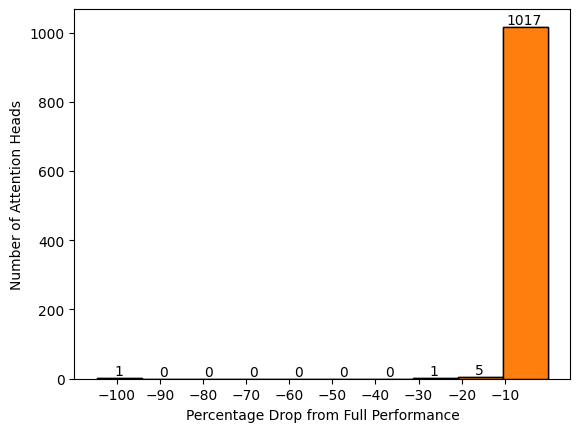

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [ ]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)

if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -0.41508000204339623


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## plot heatmap

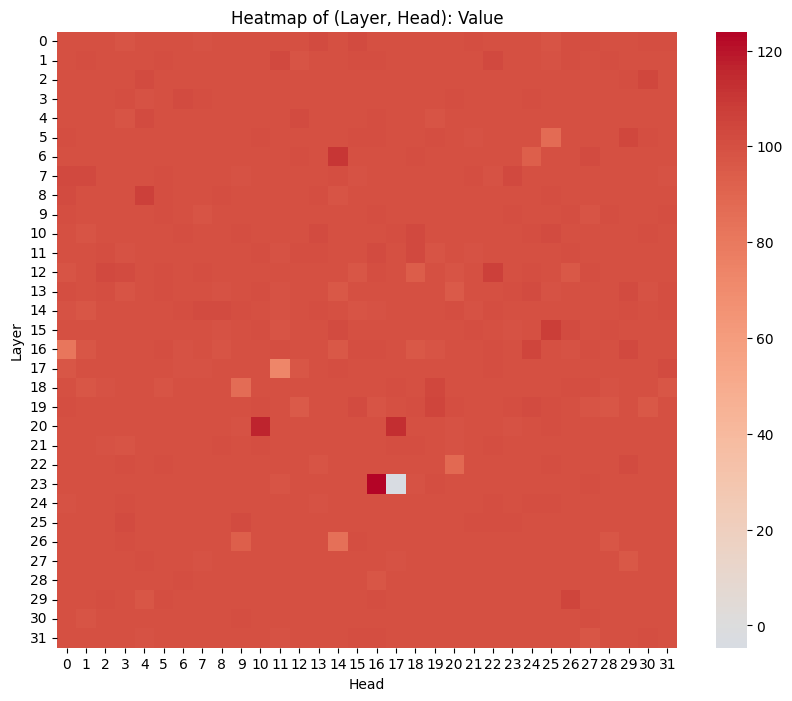

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dictionary to a DataFrame
data_list = [(key[0], key[1], value) for key, value in lh_scores.items()]
df = pd.DataFrame(data_list, columns=['Layer', 'Head', 'Value'])

# Create a pivot table
pivot_table = df.pivot(index='Layer', columns='Head', values='Value').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pivot_table, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Heatmap of (Layer, Head): Value')

# Rotate y-axis numbers to horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

# Find Impt MLPs from Full

In [ ]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 92.01597595214844
1 94.00399017333984
2 95.81803131103516
3 103.45388793945312
4 88.051025390625
5 99.47391510009766
6 91.8596420288086
7 114.85404968261719
8 96.18640899658203
9 100.8855972290039
10 93.29069519042969
11 108.46390533447266
12 107.74981689453125
13 100.97246551513672
14 111.55992126464844
15 90.01488494873047
16 66.47331237792969
17 111.83480834960938
18 102.9833755493164
19 122.36109161376953
20 96.54077911376953
21 100.13522338867188
22 121.56651306152344
23 102.99058532714844
24 104.17913055419922
25 96.92479705810547
26 103.19137573242188
27 101.30545043945312
28 103.31826782226562
29 103.32794189453125
30 109.77914428710938
31 91.73290252685547


# Node Ablation Iteration

## new fns

In [40]:
# from dataset import Dataset
# from transformer_lens import HookedTransformer, utils
# from transformer_lens.hook_points import HookPoint
# import einops
# from functools import partial
# import torch as t
# from torch import Tensor
# from typing import Dict, Tuple, List
# from jaxtyping import Float, Bool

# from node_ablation_fns import *

# def find_circuit_forw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
#     # threshold is T, a %. if performance is less than T%, allow its removal
#     # we don't ablate the curr circuits
#     if heads_not_ablate == []: # Start with full circuit
#         heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
#     if mlps_not_ablate == []:
#         mlps_not_ablate = [layer for layer in range(12)]

#     comp_scores = {}
#     for layer in range(0, 12):
#         for head in range(12):
#             print(layer, head)
#             if (layer, head) not in heads_not_ablate:
#                 continue

#             copy_heads_not_ablate = heads_not_ablate.copy()
#             copy_heads_not_ablate.remove((layer, head))

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[layer] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 heads_not_ablate.remove((layer, head))
#                 print("Removed:", (layer, head))
#             del(new_logits)

#         print(layer)
#         if layer in mlps_not_ablate:
#             copy_mlps_not_ablate = mlps_not_ablate.copy()
#             copy_mlps_not_ablate.remove(layer)

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[(layer, head)] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 mlps_not_ablate.remove(layer)
#                 print("Removed: MLP ", layer)
#             del(new_logits)

#     return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

def find_circuit_backw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(32) for head in range(32)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(32)]

    comp_scores = {}
    for layer in range(31, -1, -1):  # go thru all heads in a layer first
        print(layer)
        if layer in mlps_not_ablate:
            copy_mlps_not_ablate = mlps_not_ablate.copy()
            copy_mlps_not_ablate.remove(layer)

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[layer] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                mlps_not_ablate.remove(layer)
                print("Removed: MLP ", layer)
            del(new_logits)

        for head in range(32):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

            new_logits = ablated_model(dataset.toks)
            new_score = get_logit_diff(new_logits, dataset)
            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(new_logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

## run

In [41]:
# threshold = 20
# curr_circ_heads = []
# curr_circ_mlps = []
# prev_score = 100
# new_score = 0
# iter = 1
# all_comp_scores = []
# while prev_score != new_score:
#     print('\nbackw prune, iter ', str(iter))
#     old_circ_heads = curr_circ_heads.copy() # save old before finding new one
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     print('\nfwd prune, iter ', str(iter))
#     # track changes in circuit as for some reason it doesn't work with scores
#     old_circ_heads = curr_circ_heads.copy()
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     iter += 1

In [42]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
# while prev_score != new_score:
# print('\nbackw prune, iter ', str(iter))
old_circ_heads = curr_circ_heads.copy() # save old before finding new one
old_circ_mlps = curr_circ_mlps.copy()
curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)

31
(cand circuit / full) %: 101.7712
Removed: MLP  31
31 0
(cand circuit / full) %: 101.7695
Removed: (31, 0)
31 1
(cand circuit / full) %: 101.7319
Removed: (31, 1)
31 2
(cand circuit / full) %: 101.7402
Removed: (31, 2)
31 3
(cand circuit / full) %: 101.7218
Removed: (31, 3)
31 4
(cand circuit / full) %: 101.7120
Removed: (31, 4)
31 5
(cand circuit / full) %: 101.8683
Removed: (31, 5)
31 6
(cand circuit / full) %: 101.8561
Removed: (31, 6)
31 7
(cand circuit / full) %: 101.8757
Removed: (31, 7)
31 8
(cand circuit / full) %: 101.4305
Removed: (31, 8)
31 9
(cand circuit / full) %: 101.3982
Removed: (31, 9)
31 10
(cand circuit / full) %: 103.2751
Removed: (31, 10)
31 11
(cand circuit / full) %: 102.5219
Removed: (31, 11)
31 12
(cand circuit / full) %: 102.5599
Removed: (31, 12)
31 13
(cand circuit / full) %: 102.5301
Removed: (31, 13)
31 14
(cand circuit / full) %: 102.5703
Removed: (31, 14)
31 15
(cand circuit / full) %: 101.8424
Removed: (31, 15)
31 16
(cand circuit / full) %: 101.833

In [49]:
with open('spanishNW_b_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('spanishNW_b_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
curr_circ_heads

[(0, 2),
 (0, 7),
 (0, 13),
 (0, 21),
 (1, 4),
 (1, 5),
 (1, 23),
 (1, 24),
 (1, 31),
 (2, 0),
 (2, 2),
 (2, 3),
 (2, 17),
 (2, 22),
 (2, 24),
 (2, 26),
 (2, 30),
 (2, 31),
 (3, 23),
 (3, 24),
 (3, 30),
 (5, 25),
 (6, 11),
 (7, 0),
 (7, 30),
 (8, 0),
 (8, 6),
 (8, 8),
 (8, 11),
 (9, 26),
 (11, 18),
 (11, 23),
 (11, 24),
 (11, 25),
 (11, 28),
 (12, 6),
 (12, 18),
 (12, 22),
 (12, 23),
 (12, 26),
 (12, 31),
 (13, 5),
 (13, 6),
 (13, 7),
 (13, 9),
 (13, 10),
 (13, 11),
 (13, 12),
 (13, 19),
 (13, 20),
 (14, 7),
 (14, 22),
 (14, 31),
 (16, 0),
 (16, 24),
 (17, 19),
 (17, 22),
 (20, 17),
 (22, 25)]

In [45]:
curr_circ_mlps

[0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 20, 22, 24, 26, 28]

## Find most impt heads from circ

In [46]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 82.5670


In [47]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 2)
(cand circuit / full) %: 81.8383
removed: (0, 7)
(cand circuit / full) %: 80.8690
removed: (0, 13)
(cand circuit / full) %: 82.9242
removed: (0, 21)
(cand circuit / full) %: 82.1021
removed: (1, 4)
(cand circuit / full) %: 82.6086
removed: (1, 5)
(cand circuit / full) %: 83.0149
removed: (1, 23)
(cand circuit / full) %: 82.6688
removed: (1, 24)
(cand circuit / full) %: 81.8448
removed: (1, 31)
(cand circuit / full) %: 82.0584
removed: (2, 0)
(cand circuit / full) %: 82.2946
removed: (2, 2)
(cand circuit / full) %: 82.1640
removed: (2, 3)
(cand circuit / full) %: 82.6926
removed: (2, 17)
(cand circuit / full) %: 82.4992
removed: (2, 22)
(cand circuit / full) %: 81.7485
removed: (2, 24)
(cand circuit / full) %: 82.1335
removed: (2, 26)
(cand circuit / full) %: 82.3670
removed: (2, 30)
(cand circuit / full) %: 81.8792
removed: (2, 31)
(cand circuit / full) %: 82.4448
removed: (3, 23)
(cand circuit / full) %: 81.8754
removed: (3, 24)
(cand circuit / full) %: 82.3489
removed

In [48]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(20, 17) -29.36
(16, 0) -13.63
(7, 0) -11.4
(22, 25) -10.35
(8, 0) -7.38
(12, 26) -3.38
(6, 11) -2.6
(16, 24) -2.35
(5, 25) -2.07
(12, 18) -1.74
(0, 7) -1.7
(2, 22) -0.82
(7, 30) -0.75
(0, 2) -0.73
(1, 24) -0.72
(14, 31) -0.69
(3, 23) -0.69
(2, 30) -0.69
(14, 22) -0.6
(1, 31) -0.51
(0, 21) -0.46
(2, 24) -0.43
(11, 28) -0.41
(2, 2) -0.4
(13, 20) -0.37
(8, 11) -0.36
(12, 22) -0.32
(13, 10) -0.31
(2, 0) -0.27
(3, 24) -0.22
(11, 25) -0.21
(2, 26) -0.2
(17, 22) -0.2
(13, 11) -0.17
(8, 6) -0.17
(12, 31) -0.13
(2, 31) -0.12
(12, 6) -0.12
(11, 18) -0.11
(13, 12) -0.1
(11, 23) -0.09
(2, 17) -0.07
(13, 19) -0.06
(11, 24) -0.05
(13, 7) -0.03
(14, 7) -0.0
(3, 30) 0.0
(17, 19) 0.02
(1, 4) 0.04
(9, 26) 0.05
(13, 9) 0.07
(1, 23) 0.1
(12, 23) 0.1
(2, 3) 0.13
(8, 8) 0.13
(13, 5) 0.14
(0, 13) 0.36
(13, 6) 0.39
(1, 5) 0.45


# Run on other task's circuits

In [ ]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 87.3488


In [ ]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 43.7440


In [ ]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -6.6992


In [ ]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 37.7001
